In [ ]:
import rasterio as rio
from pathlib import Path
import os
import rasterio.plot as rioplot
import numpy
import elapid as ela
import geopandas as gpd
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import metrics
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

These examples replicate [Virkkala et al. (2021). Developing fine-grained nationwide predictions of valuable forests using biodiversity indicator bird species](https://esajournals.onlinelibrary.wiley.com/doi/10.1002/eap.2505) with `elapid`. .asc-files used in these examples can be found from [here](https://ckan.ymparisto.fi/dataset/environmental-data-used-in-the-modelling-of-suitable-nesting-sites-for-six-forest-biodiversity-) and [here](https://ckan.ymparisto.fi/dataset/environmental-data-used-in-the-modelling-of-suitable-nesting-sites-for-six-forest-biodiversity-1), and results can be found on Zenodo portal: [https://zenodo.org/records/4779108](https://zenodo.org/records/4779108).

The data of nesting sites of the bird species are not open access data due to its sensitivity, but can be requested for research purposes by sending a query to the head of the Zoology unit at the Finnish Museum of Natural History.

# Data conversion and loading

In [ ]:
datapath = Path('../data')

First some Finnish-to-English conversion for the different layer names

In [ ]:
fin_to_eng_layers= {
    'pelto_5_96': 'agri_area_96m',
    'yhd_ppa_96m': 'basal_area_96m',
    'yhd_lehti_vol_96m': 'deci_tree_volume_96m',
    'paapuu_96m_123': 'dominant_tree_species_96m',
    'runsp_5_96': 'forest_peatland_96m',
    'kost_5_96': 'marshland_96m',
    'avos_96': 'open_mire_96m',
    'corine_rantametsa_96m_pros': 'shore_forests_96m',
    'kp_luokiteltu_96m_final': 'site_type_96m',
    'harvap_5_96': 'sparse_forest_peatland_96m',
    'yhd_age_96m': 'tree_age_96m',
    'yhd_diam_96m': 'tree_diameter_96m',
    'yhd_pituus_96m': 'tree_height_96m',
    'yhd_vol_96m': 'tree_volume_96m',
    'urban_5_96m': 'urban_area_96m',
    'vesi_96': 'water_area_96m',
    'pelto_25_96': 'agri_area_500m',
    'runsp25_96': 'forest_peatland_500m',
    'kost_25_96': 'marshland_500m',
    'avos_25_96': 'open mire_500m',
    'corine_rantametsa_500m_pros': 'shore_forest_500m',
    'yhd_fert_majority_30x30_96m': 'site_type_500m',
    'harvapuust_30x30_96m': 'sparse_forest_peatland_500m',
    'yhd_age_30x30_96m': 'tree_age_500m',
    'yhd_vol_30x30_96m': 'tree_volume_500m',
    'urban_25_96': 'urban_area_500m',
    'vesi_25_96': 'water_area_500m',
    'pelto_50_96': 'agri_area_1km',
    'runsp_50_96': 'forest_peatland_1km',
    'kost_50_96': 'marshland_1km',
    'avos_50_96': 'open mire_1km',
    'corine_rantametsa_1km_pros': 'shore_forest_1km',
    'yhd_fert_majority_60x60_96m': 'site_type_1km',
    'harvap_50_96m': 'sparse_forest_peatland_1km',
    'yhd_age_60x60': 'tree_age_1km',
    'yhd_vol_60x60_96m': 'tree_volume_1km',
    'urban_50_96': 'urban_area_1km',
    'vesi_50_96': 'water_area_1km',
    'gdd5_96m': 'GDD5',
    'jan_96m': 'TJan'
}

And the layers used for different species.

In [ ]:
denmin_fin_layers = ['corine_rantametsa_500m_pros', 'corine_rantametsa_96m_pros', 'jan_96m', 'kost_25_96', 
                     'paapuu_96m_123', 'runsp25_96', 'urban_25_96', 'vesi_25_96', 'yhd_age_96m', 
                     'yhd_fert_majority_30x30_96m', 'yhd_lehti_vol_96m', 'yhd_vol_96m']

denleu_fin_layers = ['corine_rantametsa_500m_pros', 'jan_96m', 'kost_25_96', 'kp_luokiteltu_96m_final', 'paapuu_96m_123',
                     'runsp25_96', 'vesi_25_96', 'yhd_diam_96m', 'yhd_fert_majority_30x30_96m', 'yhd_lehti_vol_96m', 
                     'yhd_pituus_96m', 'yhd_vol_30x30_96m']

pictri_fin_layers = ['jan_96m', 'kp_luokiteltu_96m_final', 'paapuu_96m_123', 'pelto_5_96', 'urban_25_96', 
                     'vesi_25_96', 'yhd_age_96m', 'yhd_fert_majority_30x30_96m', 'yhd_pituus_96m', 'yhd_vol_30x30_96m', 'yhd_vol_96m']

perapi_fin_layers = ['gdd5_96m', 'kp_luokiteltu_96m_final', 'paapuu_96m_123', 'pelto_50_96', 'urban_5_96m', 'yhd_fert_majority_60x60_96m', 
                     'yhd_lehti_vol_96m', 'yhd_pituus_96m', 'yhd_vol_96m']

accgen_fin_layers = ['jan_96m', 'kp_luokiteltu_96m_final', 'pelto_5_96', 'urban_50_96', 'urban_5_96m',
                     'vesi_96', 'yhd_age_96m', 'yhd_diam_96m', 'yhd_vol_60x60_96m', 'yhd_vol_96m']

butbut_fin_layers = ['gdd5_96m', 'pelto_50_96', 'urban_50_96', 'urban_5_96m', 'vesi_50_96', 'vesi_96',
                     'yhd_age_96m', 'yhd_fert_majority_60x60_96m', 'yhd_lehti_vol_96m', 'yhd_pituus_96m',
                     'yhd_vol_60x60_96m', 'yhd_vol_96m']

## Convert ascii files to geotiff

One major advantage of not using Maxent software directly is that data doesn't have to be .asc, but they can be GeoTiffs. They can even be in different coordinate systems.

First get the locations of all input layers

In [ ]:
asc_datapath = Path('../data/ascii')
files_96m_asc = [f for f in os.listdir(asc_datapath) if f.endswith('96m.asc')]
files_500m_asc = [f for f in os.listdir(asc_datapath) if f.endswith('500m.asc')]
files_1km_asc = [f for f in os.listdir(asc_datapath) if f.endswith('1km.asc')]
other_files_asc = ['GDD5.asc', 'TJan.asc']
bias_files_asc = ['Bias_Heini_vajaa_100km.asc']

asc_files = files_96m_asc + files_500m_asc + files_1km_asc + other_files_asc + bias_files_asc
asc_files = [asc_datapath/f for f in asc_files]

crs = 'EPSG:3067'

And then convert them into GeoTiffs

In [ ]:
for f in tqdm(asc_files):
    with rio.open(f) as src:
        prof = src.profile
        data = src.read()
    prof.update({'crs':crs, 'driver':'GTiff', 'compress':'LZW', 'predictor':2, 'BIGTIFF':'YES'})
    with rio.open(datapath/f'{f.stem}.tif', 'w', **prof) as dest:
        dest.write(data)

100%|███████████████████████████████████████████████████████████████████| 42/42 [12:22<00:00, 17.69s/it]


## Read GeoTiff files

Get the locations of all of the layers here

In [ ]:
files_96m = [f for f in os.listdir(datapath) if f.endswith('96m.tif')]
files_500m = [f for f in os.listdir(datapath) if f.endswith('500m.tif')]
files_1km = [f for f in os.listdir(datapath) if f.endswith('1km.tif')]
other_files = ['GDD5.tif', 'TJan.tif']
bias_file = 'Bias_Heini_vajaa_100km.tif'

inp_layer_names = files_96m + files_500m + files_1km + other_files
labels = [f.split('.')[0] for f in inp_layer_names]
inp_layers = [datapath/l for l in inp_layer_names]

Note which features are categorical instead of continous

In [ ]:
cat_features = [
    'dominant_tree_species_96m',
    #'site_type_96m', # Technically ordinal features
    #'site_type_500m', # Technically ordinal features
    #'site_type_1km', # Technically ordinal features
]

# Modelling

Read bird location file and convert it to `gpd.GeoDataFrame`.

In [ ]:
bird_data = pd.read_csv('../birds_final.csv')
bird_data_gdf = gpd.GeoDataFrame(bird_data, geometry=gpd.points_from_xy(bird_data.longitude, bird_data.latitude), crs='EPSG:3067')
bird_data_gdf.to_file(datapath/'birds.geojson')

Get more descriptive species names

In [ ]:
sp_dict = {'DENMIN': 'Dryobates minor',
           'ACCGEN': 'Accipiter gentilis',
           'BUTBUT': 'Buteo buteo',
           'DENLEU': 'Dendrocopos leucotos',
           'PERAPI': 'Pernis apivorus',
           'PICTRI': 'Picoide tridactylus'}

In [ ]:
bird_data_gdf['species'] = bird_data_gdf.species.apply(lambda row: sp_dict[row])

In [ ]:
species = bird_data_gdf.species.unique()

In [ ]:
bird_data_gdf['species'].value_counts()

Accipiter gentilis      4219
Buteo buteo             2070
Pernis apivorus          416
Picoide tridactylus      204
Dendrocopos leucotos     182
Dryobates minor          123
Name: species, dtype: int64

Now start modelling.

## *Dryobates minor* 

<Axes: >

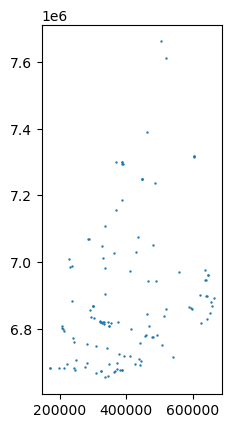

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Dryobates minor'].plot(markersize=0.5)

Sample 10,000 points for background from the bias file.

count                      10000
unique                      9999
top       POINT (614464 7369840)
freq                           2
dtype: object

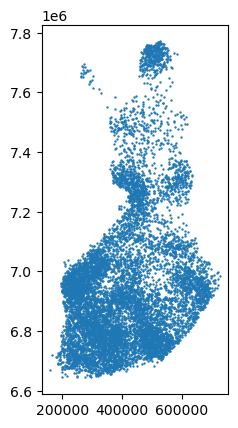

In [ ]:
pseudoabsence_bias = ela.sample_bias_file(datapath/bias_file, 10_000)
pseudoabsence_bias.plot(markersize=0.5)
pseudoabsence_bias.describe()

Annotate points.

In [ ]:
denmin_locs = bird_data_gdf[bird_data_gdf.species == 'Dryobates minor'].geometry
denmin_presence = ela.annotate(denmin_locs, inp_layers, labels=labels, drop_na=True)
background = ela.annotate(pseudoabsence_bias, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Sample:   0%|                              | 0/123 [00:00<?, ?it/s]

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Sample:   0%|                              | 0/10000 [00:00<?, ?it/s]

Took around two minutes to annotate around 15k points from 40 rasters.

Specify which layers were used for modelling this species by Virkkala et al.:

In [ ]:
denmin_layers = [fin_to_eng_layers[l] for l in denmin_fin_layers]
denmin_layers

['shore_forest_500m',
 'shore_forests_96m',
 'TJan',
 'marshland_500m',
 'dominant_tree_species_96m',
 'forest_peatland_500m',
 'urban_area_500m',
 'water_area_500m',
 'tree_age_96m',
 'site_type_500m',
 'deci_tree_volume_96m',
 'tree_volume_96m']

Specify which index has the categorical data.

In [ ]:
denmin_cat_idx = [4]

And then model the distribution. Hyperparameters are similar to Maxent software.

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(denmin_presence, background, add_class_label=True)

xtrain = train[denmin_layers]
ytrain = train['class']
denmin_pred_layers = [datapath/f'{l}.tif' for l in denmin_layers]
maxent.fit(xtrain, ytrain, categorical=denmin_cat_idx) 

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

Check the training AUC score:

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.921


Check the permutation importance plot for the model.

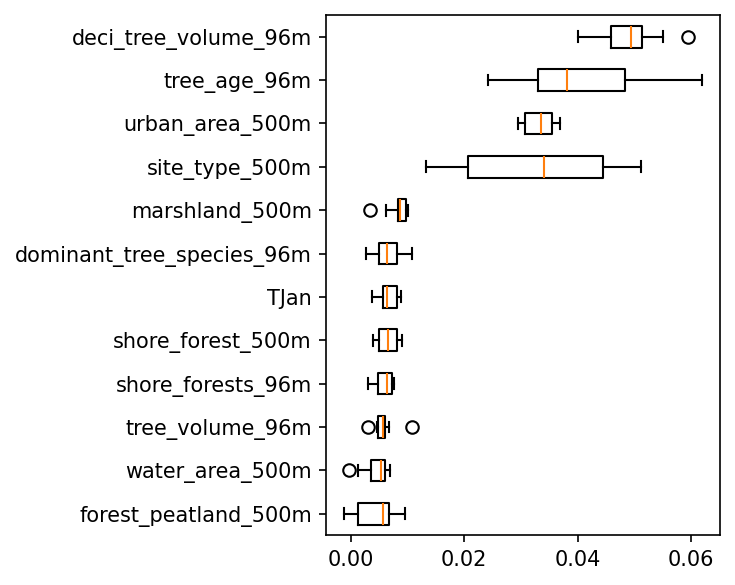

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=denmin_layers)

Write the predictions to a file in order to compare them with references.

In [ ]:
output = 'denmin_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, denmin_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

In [ ]:
comp = '../maxent_results/DENMIN_Full_data.asc'
res = 'denmin_preds_nosplit_glmnet.tif'

with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

Assert that the values are equal.

In [ ]:
comp_vals.shape, res_vals.shape

((12420, 6180), (12420, 6180))

Compute pixel-wise R² and MAE.

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.999999999935762

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.011880678

## *Accipiter gentilis*

<Axes: >

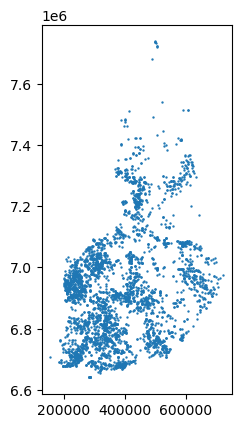

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Accipiter gentilis'].plot(markersize=0.5)

In [ ]:
accgen_locs = bird_data_gdf[bird_data_gdf.species == 'Accipiter gentilis'].geometry
accgen_presence = ela.annotate(accgen_locs, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

Sample:   0%|                              | 0/4219 [00:00<?, ?it/s]

In [ ]:
accgen_layers = [fin_to_eng_layers[l] for l in accgen_fin_layers]
accgen_layers

['TJan',
 'site_type_96m',
 'agri_area_96m',
 'urban_area_1km',
 'urban_area_96m',
 'water_area_96m',
 'tree_age_96m',
 'tree_diameter_96m',
 'tree_volume_1km',
 'tree_volume_96m']

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(accgen_presence, background, add_class_label=True)

xtrain = train[accgen_layers]
ytrain = train['class']
accgen_pred_layers = [datapath/f'{l}.tif' for l in accgen_layers]
maxent.fit(xtrain, ytrain)

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.862


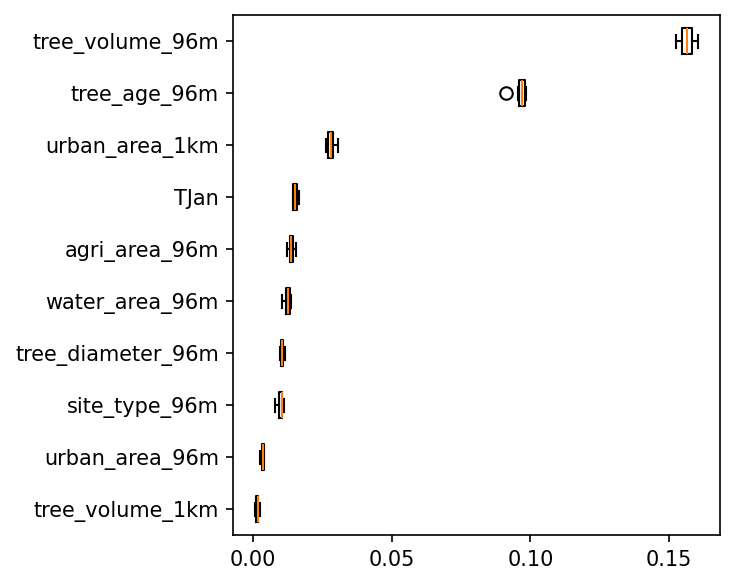

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=accgen_layers)

In [ ]:
output = 'accgen_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, accgen_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

In [ ]:
comp = '../maxent_results/ACCGEN_Full_data.asc'
res = 'accgen_preds_nosplit_glmnet.tif'


with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

In [ ]:
comp_vals.shape, res_vals.shape

((12420, 6180), (12420, 6180))

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.9999999989227947

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.09207188

## *Buteo buteo*

<Axes: >

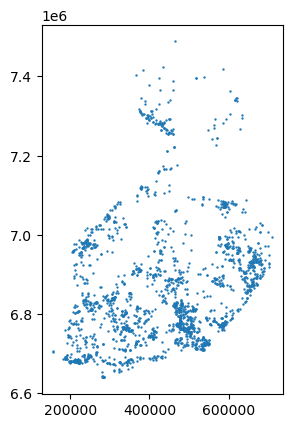

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Buteo buteo'].plot(markersize=0.5)

In [ ]:
butbut_locs = bird_data_gdf[bird_data_gdf.species == 'Buteo buteo'].geometry
butbut_presence = ela.annotate(butbut_locs, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

In [ ]:
butbut_layers = [fin_to_eng_layers[l] for l in butbut_fin_layers]
butbut_layers

['GDD5',
 'agri_area_1km',
 'urban_area_1km',
 'urban_area_96m',
 'water_area_1km',
 'water_area_96m',
 'tree_age_96m',
 'site_type_1km',
 'deci_tree_volume_96m',
 'tree_height_96m',
 'tree_volume_1km',
 'tree_volume_96m']

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(butbut_presence, background, add_class_label=True)

xtrain = train[butbut_layers]
ytrain = train['class']
butbut_pred_layers = [datapath/f'{l}.tif' for l in butbut_layers]
maxent.fit(xtrain, ytrain)

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.847


In [ ]:
output = 'butbut_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, butbut_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

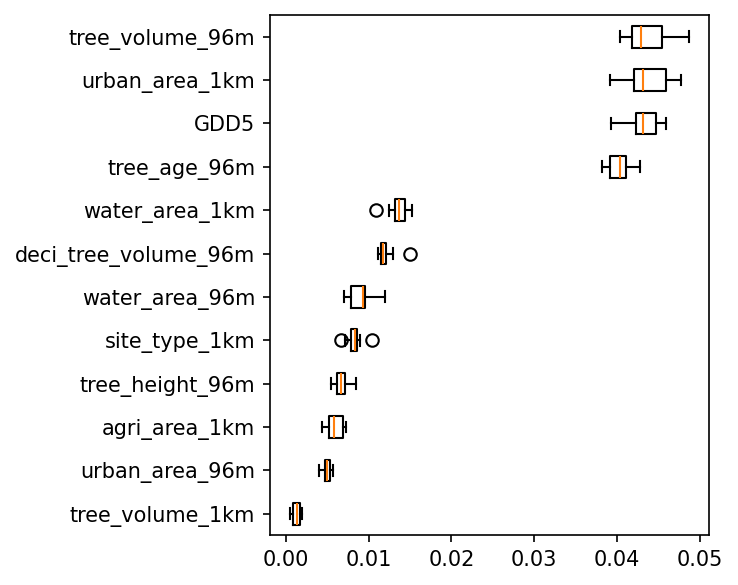

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=butbut_layers)

In [ ]:
comp = '../maxent_results/BUTBUT_Full_data.asc'
res = 'butbut_preds_nosplit_glmnet.tif'


with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.9999999994989272

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.05679366

## *Dendrocopos leucotos*

<Axes: >

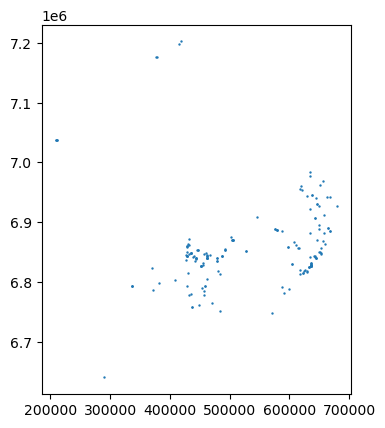

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Dendrocopos leucotos'].plot(markersize=0.5)

In [ ]:
denleu_locs = bird_data_gdf[bird_data_gdf.species == 'Dendrocopos leucotos'].geometry
denleu_presence = ela.annotate(butbut_locs, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

In [ ]:
denleu_layers = [fin_to_eng_layers[l] for l in denleu_fin_layers]
denleu_layers

['shore_forest_500m',
 'TJan',
 'marshland_500m',
 'site_type_96m',
 'dominant_tree_species_96m',
 'forest_peatland_500m',
 'water_area_500m',
 'tree_diameter_96m',
 'site_type_500m',
 'deci_tree_volume_96m',
 'tree_height_96m',
 'tree_volume_500m']

In [ ]:
denleu_cat_idx = [4]

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(denleu_presence, background, add_class_label=True)

xtrain = train[denleu_layers]
ytrain = train['class']
denleu_pred_layers = [datapath/f'{l}.tif' for l in denleu_layers]
maxent.fit(xtrain, ytrain, categorical=denleu_cat_idx)

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.825


In [ ]:
output = 'denleu_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, denleu_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

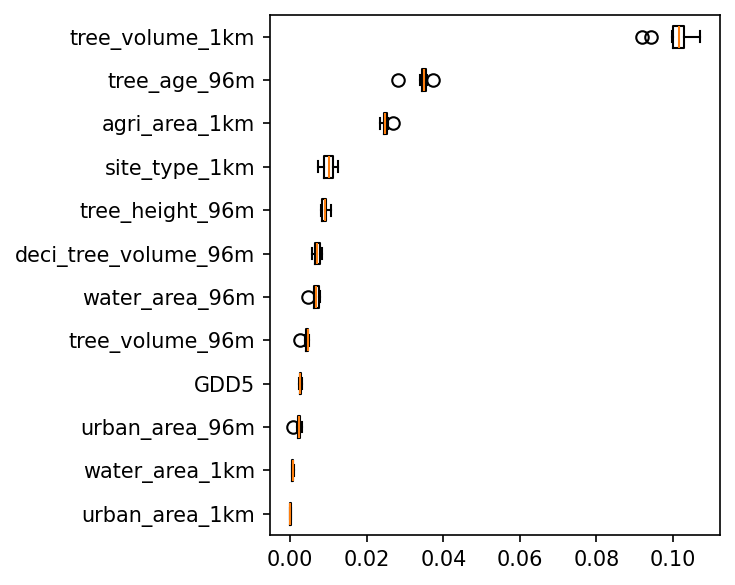

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=butbut_layers)

In [ ]:
comp = '../maxent_results/DENLEU_Full_data.asc'
res = 'denleu_preds_nosplit_glmnet.tif'


with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.9999999985785417

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.080428004

## *Pernis apivorus*

<Axes: >

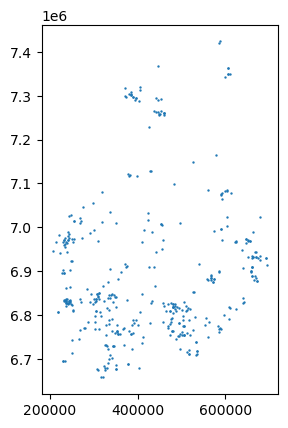

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Pernis apivorus'].plot(markersize=0.5)

In [ ]:
perapi_locs = bird_data_gdf[bird_data_gdf.species == 'Pernis apivorus'].geometry
perapi_presence = ela.annotate(butbut_locs, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

In [ ]:
perapi_layers = [fin_to_eng_layers[l] for l in perapi_fin_layers]
perapi_layers

['GDD5',
 'site_type_96m',
 'dominant_tree_species_96m',
 'agri_area_1km',
 'urban_area_96m',
 'site_type_1km',
 'deci_tree_volume_96m',
 'tree_height_96m',
 'tree_volume_96m']

In [ ]:
perapi_cat_idx = [2]

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(perapi_presence, background, add_class_label=True)

xtrain = train[perapi_layers]
ytrain = train['class']
perapi_pred_layers = [datapath/f'{l}.tif' for l in perapi_layers]
maxent.fit(xtrain, ytrain, categorical=perapi_cat_idx)

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.816


In [ ]:
output = 'perapi_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, perapi_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

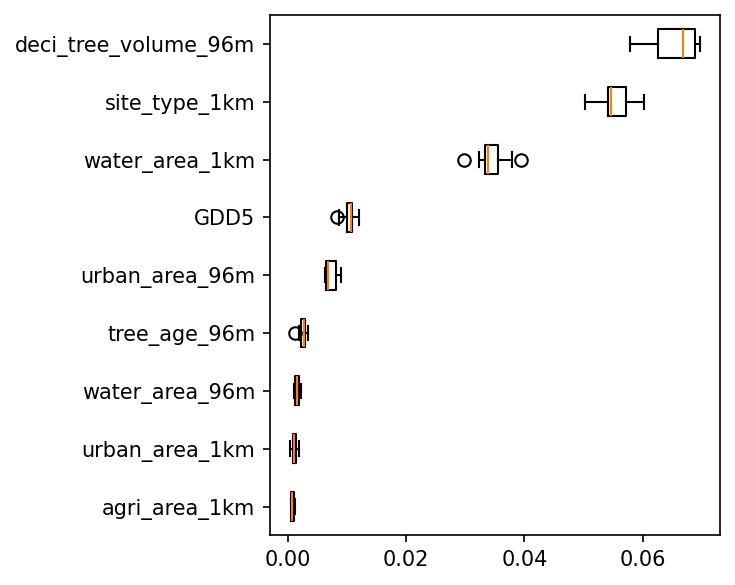

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=butbut_layers)

In [ ]:
comp = '../maxent_results/PERAPI_Full_data_NEW.asc'
res = 'perapi_preds_nosplit_glmnet.tif'


with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.9999999995853329

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.044652212

## *Picoide tridactylus*

<Axes: >

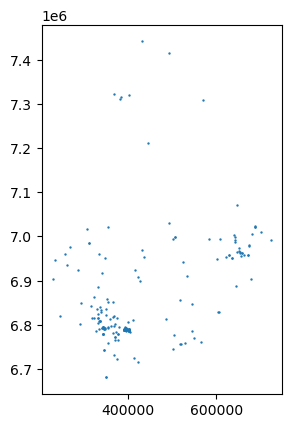

In [ ]:
bird_data_gdf[bird_data_gdf.species == 'Picoide tridactylus'].plot(markersize=0.5)

In [ ]:
pictri_locs = bird_data_gdf[bird_data_gdf.species == 'Picoide tridactylus'].geometry
pictri_presence = ela.annotate(butbut_locs, inp_layers, labels=labels, drop_na=True)

Raster:   0%|                              | 0/40 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

Sample:   0%|                              | 0/2070 [00:00<?, ?it/s]

In [ ]:
pictri_layers = [fin_to_eng_layers[l] for l in pictri_fin_layers]
pictri_layers

['TJan',
 'site_type_96m',
 'dominant_tree_species_96m',
 'agri_area_96m',
 'urban_area_500m',
 'water_area_500m',
 'tree_age_96m',
 'site_type_500m',
 'tree_height_96m',
 'tree_volume_500m',
 'tree_volume_96m']

In [ ]:
pictri_cat_idx = [2]

In [ ]:
maxent = ela.MaxentModel(transform='cloglog', 
                         beta_lqp=0.05, 
                         beta_hinge=0.5,
                         beta_categorical=0.25,
                         beta_threshold=1.0,
                         feature_types=['linear', 'product', 'hinge'],
                         use_lambdas='best',
                         beta_multiplier=1.5,
                         n_hinge_features=10)

train = ela.stack_geodataframes(pictri_presence, background, add_class_label=True)

xtrain = train[pictri_layers]
ytrain = train['class']

pictri_pred_layers = [datapath/f'{l}.tif' for l in pictri_layers]
maxent.fit(xtrain, ytrain, categorical=pictri_cat_idx)

MaxentModel(beta_categorical=0.25, beta_hinge=0.5, beta_lqp=0.05,
            feature_types=['linear', 'product', 'hinge'])

In [ ]:
ypred = maxent.predict(xtrain)
auc = metrics.roc_auc_score(ytrain, ypred)
print(f"Training AUC score: {auc:0.3f}")

Training AUC score: 0.844


In [ ]:
output = 'pictri_preds_nosplit_glmnet.tif'

ela.apply_model_to_rasters(maxent, pictri_pred_layers, output, quiet=False)

Window:   0%|                              | 0/12420 [00:00<?, ?it/s]

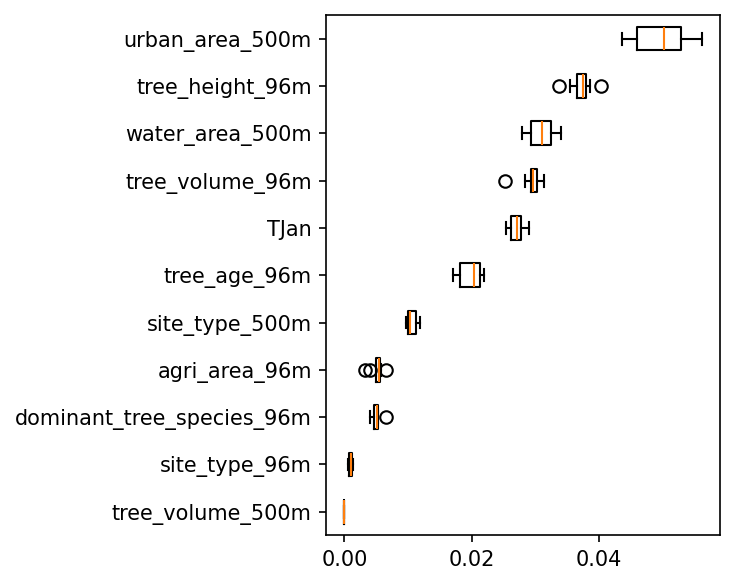

In [ ]:
fig, ax = maxent.permutation_importance_plot(x=xtrain, y=ytrain, labels=pictri_layers)

In [ ]:
comp = '../maxent_results/PICTRI_Full_data.asc'
res = 'pictri_preds_nosplit_glmnet.tif'

with rio.open(comp) as src:
    comp_vals = src.read(1)
with rio.open(res) as src:
    res_vals = src.read(1)

In [ ]:
metrics.r2_score(comp_vals.flatten(), res_vals.flatten())

0.9999999994508276

In [ ]:
metrics.mean_absolute_error(comp_vals.flatten(), res_vals.flatten())

0.0443944